
<h1 id="FPL-Mean-Reversion">FPL Mean Reversion<a class="anchor-link" href="#FPL-Mean-Reversion">¶</a></h1><p>We will apply the Follow the Perturbed Leader algorithm to select the best hyperparameter for a mean reversion strategy on bitcoin data.</p>



<h2 id="Imports">Imports<a class="anchor-link" href="#Imports">¶</a></h2>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
gen = np.random.default_rng(seed=42)
%matplotlib inline


<h2 id="Load-Data">Load Data<a class="anchor-link" href="#Load-Data">¶</a></h2>


In [2]:
fname = 'csv_data/clean_data/spy_dailys_clean_dtd.csv'
returns = {}  # Dictionary {date: return}
with open(fname) as f:
    fl = True
    for line in f:
        if fl:
            fl = False  # ignore the header
        else:
            parsed = line.strip().split(",")
            returns[parsed[1]] = float(parsed[2])  # date, return -> {date: return}


<h2 id="Mean-Reversion-Class">Mean Reversion Class<a class="anchor-link" href="#Mean-Reversion-Class">¶</a></h2>


In [3]:

import collections


class MeanReversion(object):
    """
    Simple mean reversion strategy that takes position that the difference between yesterday's 
    return and the k-day average.
    """
    
    def __init__(self, k):
        """
        Initialize the class
        :param k: The mean reversion parameter (number of days to look back)
        """
        self.k = k
        self.returns = collections.deque(maxlen=k)
    
    def update(self, ret):
        """
        Calculate the position given the return
        :param ret: The return
        :return: The position (-1, 0, or 1)
        """
        pos = 0.0
        if len(self.returns) == self.k:
            pos = -1.0 * np.sign(ret - np.mean(np.array(list(self.returns))))
        self.returns.append(ret)
        return pos
    




<h2 id="Helper-Functions">Helper Functions<a class="anchor-link" href="#Helper-Functions">¶</a></h2>


In [4]:

def loss(pos, ret):
    """
    The loss between the position and the return (0 if same sign, 1 if opposite signs)
    :param pos: The position taken
    :param ret: The return of the asset
    :return: The loss (0 if same sign, 1 if opposite signs)
    """
    return 1 - ((np.sign(pos) * np.sign(ret)) + 1) / 2

def position_return(pos, ret):
    """
    The return of the position given the return.
    :param pos: The position taken
    :param ret: The return of the asset
    :return: The return on the position
    """
    return pos * ret

def _get_x_dates(dates):
    """
    Get the dates for x axis
    :param dates: List of all dates
    :return: the index and strings for x ticks
    """
    dates = np.array(sorted(dates))
    x_idx = np.linspace(0, len(dates) - 1, 10).astype(int)
    x_dates = dates[x_idx]
    return x_idx, x_dates

def visualize_returns(dates, return_list, name_list, black=None):
    """
    Visualize the cumulative returns
    :param dates: The dates
    :param return_list: List of strategy returns
    :param name_list: List of the strategy names
    """
    x_idx, x_dates = _get_x_dates(dates)
    plt.figure(figsize=(10,8))
    for i, name in enumerate(name_list):
        if black is None or name != black:
            plt.plot(np.cumsum(return_list[i]), label=name)
        else:
            plt.plot(np.cumsum(return_list[i]), label=name, color="k")
    plt.xticks(x_idx, x_dates, rotation=-90)
    plt.legend()
    plt.title('return by strategy')
    plt.show()
    
def visualize_weights(dates, fpl_selection, name_list):
    x_idx, x_dates = _get_x_dates(dates)
    plt.figure(figsize=(10,4))
    for i, name in enumerate(name_list):
        plt.plot(fpl_selection[:, i], label=name)
    plt.xticks(x_idx, x_dates, rotation=-90)
    plt.legend()
    plt.title('fpl selection')
    plt.show()




<h2 id="FPL-Algorithm">FPL Algorithm<a class="anchor-link" href="#FPL-Algorithm">¶</a></h2>


In [5]:

mr_1 = MeanReversion(k=1)   # 1 day mean-reverison
mr_5 = MeanReversion(k=5)   # 5 day mean-reversion
mr_20 = MeanReversion(k=20) # 20 day mean-reversion

fpl_1_weight = 0.0  # fpl weight for 1 day mean-reversion
fpl_5_weight = 0.0  # fpl weight for 1 day mean-reversion
fpl_20_weight = 0.0 # fpl weight for 20 day mean-reversion

mr_1_returns = []
mr_5_returns = []
mr_20_returns = []
fpl_returns = []
fpl_selection = []

burn_in = 60  # This number just has to be larger than the largest k above.

dates = sorted(list(returns))
fpl_dates = []
counter = 0
yesterday_pos_1 = 0
yesterday_pos_5 = 0
yesterday_pos_20 = 0
yesterday_fpl_pos = 0
for date in dates:
    counter += 1
    ret = returns[date]
    pos_1 = mr_1.update(ret)
    pos_5 = mr_5.update(ret)
    pos_20 = mr_20.update(ret)
    if counter > burn_in:
        # calculate returns
        fpl_dates.append(date)
        mr_1_returns.append(position_return(yesterday_pos_1, ret))
        mr_5_returns.append(position_return(yesterday_pos_5, ret))
        mr_20_returns.append(position_return(yesterday_pos_20, ret))
        fpl_returns.append(position_return(yesterday_fpl_pos, ret))  # use the fpl position taken yesterday.
        # update fpl algorithm
        mr_1_loss = loss(pos_1, ret)
        mr_5_loss = loss(pos_5, ret)
        mr_20_loss = loss(pos_20, ret)
        
        fpl_1_weight += mr_1_loss + gen.exponential()
        fpl_5_weight += mr_5_loss + gen.exponential()
        fpl_20_weight += mr_20_loss + gen.exponential()
        if fpl_1_weight <= fpl_5_weight and fpl_1_weight <= fpl_20_weight:
            fpl_selection.append(np.array([1, 0, 0]))  # selection vector
            yesterday_fpl_pos = pos_1
        elif fpl_5_weight <= fpl_1_weight and fpl_5_weight <= fpl_20_weight:
            fpl_selection.append(np.array([0, 1, 0]))  # selection vector
            yesterday_fpl_pos = pos_5
        else:
            fpl_selection.append(np.array([0, 0, 1]))  # selection vector
            yesterday_fpl_pos = pos_20
        yesterday_pos_1 = pos_1
        yesterday_pos_5 = pos_5
        yesterday_pos_20 = pos_20

fpl_selection = np.array(fpl_selection)



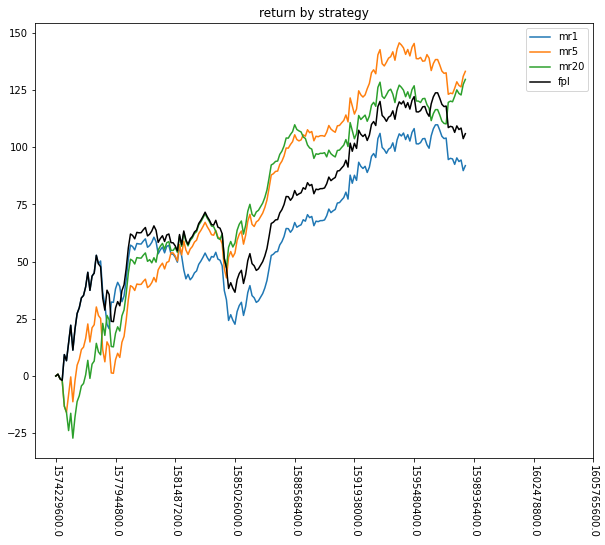

In [6]:

visualize_returns(dates, [mr_1_returns, mr_5_returns, mr_20_returns, fpl_returns], ['mr1', 'mr5', 'mr20', 'fpl'], black='fpl')



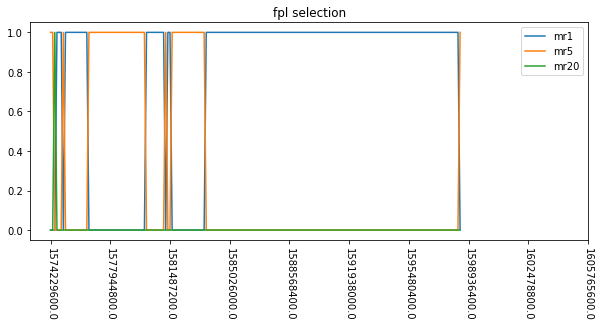

In [7]:

visualize_weights(dates, fpl_selection, ['mr1', 'mr5', 'mr20'])

